In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.io import loadmat
from scipy.interpolate import CubicSpline

In [2]:
%matplotlib inline

In [3]:
#open leaderboard data
leaderboard_data = loadmat('..\\leaderboard_data.mat')
raw_training_data = loadmat('..\\raw_training_data.mat')

In [4]:
#glove data for training - per subject
train_dg_s1 = raw_training_data['train_dg'][0][0]
train_dg_s2 = raw_training_data['train_dg'][1][0]
train_dg_s3 = raw_training_data['train_dg'][2][0]

In [5]:
train_dg_s1_downsample = train_dg_s1[::50][:-1]
train_dg_s2_downsample = train_dg_s2[::50][:-1]
train_dg_s3_downsample = train_dg_s3[::50][:-1]

In [6]:
# print(train_dg_s1_downsample.shape)
# print(feats_s1_train.shape)
# plt.scatter(feats_s1_train[:,[0:]], train_dg_s1_downsample)

In [7]:
file_s1 = open("all_feats_s1_norm_train_fx.npy", "rb")
feats_s1_train = np.load(file_s1)
file_s1.close()

file_s2 = open("all_feats_s2_norm_train_fx.npy", "rb")
feats_s2_train = np.load(file_s2)
file_s2.close()

file_s3 = open("all_feats_s3_norm_train_fx.npy", "rb")
feats_s3_train = np.load(file_s3)
file_s3.close()

In [8]:
file_s1 = open("all_feats_s1_norm_test_fx.npy", "rb")
feats_s1_test = np.load(file_s1)
file_s1.close()

file_s2 = open("all_feats_s2_norm_test_fx.npy", "rb")
feats_s2_test = np.load(file_s2)
file_s2.close()

file_s3 = open("all_feats_s3_norm_test_fx.npy", "rb")
feats_s3_test = np.load(file_s3)
file_s3.close()

In [9]:
# Problematic features, drop them for now. 
def clean_features(feats):
    bad_feat_inds = np.concatenate((np.arange(2,len(feats.transpose()),7),
                                   np.arange(3,len(feats.transpose()),7),
                                   np.arange(4,len(feats.transpose()),7),
                                  ))
    feats_cleaned = np.delete(feats, bad_feat_inds, axis=1)
    
    return feats_cleaned

feats_s1_train = clean_features(feats_s1_train)
feats_s2_train = clean_features(feats_s2_train)
feats_s3_train = clean_features(feats_s3_train)

feats_s1_test = clean_features(feats_s1_test)
feats_s2_test = clean_features(feats_s2_test)
feats_s3_test = clean_features(feats_s3_test)

In [10]:
train_inds = np.random.choice(np.arange(0,len(feats_s1_train)), 4500, replace=False)
selection_mask = np.zeros(len(feats_s1_train))
selection_mask[train_inds] = 1

In [11]:
print(train_inds*50)

[154750 274400  44950 ... 243200 266350 285600]


In [12]:
# This function is to extract the full timescale dataglove samples
def extract_dg_timesamples(bin_inds, dg_data):
    time_inds = bin_inds*50
    
    dg_data_full = []
    for t in time_inds:
        dg_data_full.extend(dg_data[t:t+50])
        
    return np.array(dg_data_full)
    
    

In [13]:
feats_s1_train_split = feats_s1_train[selection_mask.astype(bool)]
feats_s1_valid_split = feats_s1_train[~selection_mask.astype(bool)]

print(feats_s1_train_split.shape)
print(feats_s1_valid_split.shape)

feats_s2_train_split = feats_s2_train[selection_mask.astype(bool)]
feats_s2_valid_split = feats_s2_train[~selection_mask.astype(bool)]

print(feats_s2_train_split.shape)
print(feats_s2_valid_split.shape)

feats_s3_train_split = feats_s3_train[selection_mask.astype(bool)]
feats_s3_valid_split = feats_s3_train[~selection_mask.astype(bool)]

print(feats_s3_train_split.shape)
print(feats_s3_valid_split.shape)

(4500, 244)
(1499, 244)
(4500, 184)
(1499, 184)
(4500, 256)
(1499, 256)


In [14]:
dg_s1_train_split = train_dg_s1_downsample[selection_mask.astype(bool)]
dg_s1_valid_split = train_dg_s1_downsample[~selection_mask.astype(bool)]

dg_s2_train_split = train_dg_s2_downsample[selection_mask.astype(bool)]
dg_s2_valid_split = train_dg_s2_downsample[~selection_mask.astype(bool)]


dg_s3_train_split = train_dg_s3_downsample[selection_mask.astype(bool)]
dg_s3_valid_split = train_dg_s3_downsample[~selection_mask.astype(bool)]


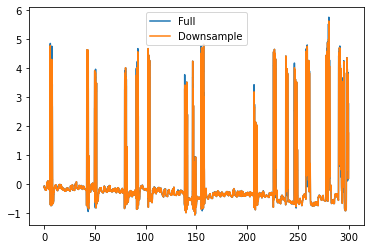

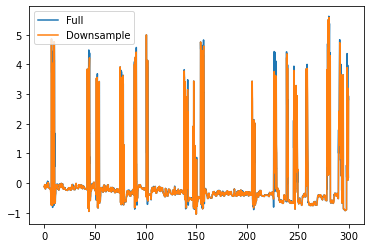

In [15]:
training_bin_inds = np.arange(0,len(feats_s1_train))[selection_mask.astype(bool)]
validation_bin_inds = np.arange(0,len(feats_s1_train))[~selection_mask.astype(bool)]

dg_s1_train_full = extract_dg_timesamples(training_bin_inds, train_dg_s1)
dg_s1_valid_full = extract_dg_timesamples(validation_bin_inds, train_dg_s1)

# Plotting to verify
plt.figure()
plt.plot(np.linspace(0,300,len(dg_s1_train_full)), dg_s1_train_full.transpose()[0])
plt.plot(np.linspace(0,300,len(dg_s1_train_split)), dg_s1_train_split.transpose()[0])
plt.legend(["Full", "Downsample"])

plt.figure()
plt.plot(np.linspace(0,300,len(dg_s1_valid_full)), dg_s1_valid_full.transpose()[0])
plt.plot(np.linspace(0,300,len(dg_s1_valid_split)), dg_s1_valid_split.transpose()[0])
plt.legend(["Full", "Downsample"])

dg_s2_train_full = extract_dg_timesamples(training_bin_inds, train_dg_s2)
dg_s2_valid_full = extract_dg_timesamples(validation_bin_inds, train_dg_s2)

dg_s3_train_full = extract_dg_timesamples(training_bin_inds, train_dg_s3)
dg_s3_valid_full = extract_dg_timesamples(validation_bin_inds, train_dg_s3)


# Training the models

Here we use a random forest regressor with 464 classifiers trained on 75% of the feature time bins

In [22]:
# Cubic spline for smoothing/interpolation
def spline_preds(preds, time_length):
    # N samples
    preds_sample_orig = np.arange(len(preds))
    
    # T time points
    preds_sample_target = np.linspace(0,len(preds),time_length)
    preds = preds.transpose()

    preds_interp = []
    
    for finger_preds in preds:
        f = CubicSpline(preds_sample_orig, finger_preds, bc_type="natural")
        new_preds = f(preds_sample_target)
        preds_interp.append(new_preds)
    
    preds_interp = np.array(preds_interp).transpose()
    
    return preds_interp

# Compute individual finger correlation for a subject
def compute_corr(preds, truth):
    subj_corr = []
    for i in range(5):
        finger_pred = preds.transpose()[i]
        finger_truth = truth.transpose()[i]
        subj_corr.append(pearsonr(finger_pred, finger_truth)[0])
    
    return subj_corr

# Gaussian filtering to clean the output
def convolve_gaussian(preds):
    preds_t = preds.transpose()
    preds_t_convolve = []
    
    fs = 1000
    gaussian_filter = np.exp(-1*(np.arange(int(-0.500*1000),int(0.500*1000)))**2/(0.50*1000)**2)
    gaussian_filter_scaled = 1/np.sum(gaussian_filter) * gaussian_filter
    
    for row in preds_t:
        preds_t_convolve.append(np.convolve(gaussian_filter_scaled, row, "same"))
    
    return np.array(preds_t_convolve).transpose()

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
rfr_reg = RandomForestRegressor(n_estimators=464).fit(feats_s1_train_split, dg_s1_train_split)

In [23]:
# Predict
pred1 = rfr_reg.predict(feats_s1_valid_split)

print(compute_corr(pred1, dg_s1_valid_split))

# Upsample the predictions and postprocess
pred1_postprocess = convolve_gaussian(spline_preds(pred1, len(dg_s1_valid_full)))

print(compute_corr(pred1_postprocess, dg_s1_valid_full))


[0.3504871036876944, 0.4503253245188443, 0.2109004721581402, 0.37781030749906686, 0.35158699131319937]
[0.5115577169905365, 0.5927658242948174, 0.3086515545649501, 0.5393782732670006, 0.5177282603875837]


In [24]:
model_fname = 'subject1_rfr_464_run1.model'
pickle.dump(rfr_reg, open(model_fname, 'wb'))

In [25]:
rfr_reg_loaded = pickle.load(open(model_fname, 'rb'))
pred = rfr_reg_loaded.predict(feats_s1_valid_split)

subj1_corr = []
for i in range(5):
    finger_pred = pred.transpose()[i]
    finger_truth = dg_s1_valid_split.transpose()[i]
    subj1_corr.append(pearsonr(finger_pred, finger_truth)[0])

print(subj1_corr)

[0.3504871036876944, 0.4503253245188443, 0.2109004721581402, 0.37781030749906686, 0.35158699131319937]


In [26]:
# SUBJECT 2
rfr_reg_s2 = RandomForestRegressor(n_estimators=464).fit(feats_s2_train_split, dg_s2_train_split)


In [28]:
# Predict
pred2 = rfr_reg_s2.predict(feats_s2_valid_split)

print(compute_corr(pred2, dg_s2_valid_split))

# Upsample the predictions and postprocess
pred2_postprocess = convolve_gaussian(spline_preds(pred2, len(dg_s2_valid_full)))

print(compute_corr(pred2_postprocess, dg_s2_valid_full))


[0.43685376172936724, 0.29916853259293186, 0.3175368919042044, 0.3911121956535511, 0.2816455109252384]
[0.5685732631291066, 0.28561468664088785, 0.37031866775256067, 0.36066218076603107, 0.36829471807350334]


In [29]:
model_fname_s2 = 'subject2_rfr_464_run1.model'
pickle.dump(rfr_reg_s2, open(model_fname_s2, 'wb'))

In [30]:
rfr_reg_s3 = RandomForestRegressor(n_estimators=464).fit(feats_s3_train_split, dg_s3_train_split)


In [31]:
# Predict
pred3 = rfr_reg_s3.predict(feats_s3_valid_split)

print(compute_corr(pred3, dg_s3_valid_split))

# Upsample the predictions and postprocess
pred3_postprocess = convolve_gaussian(spline_preds(pred3, len(dg_s3_valid_full)))

print(compute_corr(pred3_postprocess, dg_s3_valid_full))


[0.5816138443564218, 0.4821509592464216, 0.4643385882468679, 0.589443022273572, 0.5296396981819256]
[0.6906196971700848, 0.4666473108263648, 0.5944809166938982, 0.6306170851395374, 0.6645775876400254]


In [32]:
model_fname_s3 = 'subject3_rfr_464_run1.model'
pickle.dump(rfr_reg_s3, open(model_fname_s3, 'wb'))

In [28]:
pred3_all = rfr_reg_s3.predict(feats_s3_train)

pred3_all_long = []
for row in pred3_all:
    for i in range(50):
        pred3_all_long.append(row)
        
# It's short 50 entries, so add the last row 50 more times
for i in range(50):
    pred3_all_long.append(row)

pred3_all_long = np.array(pred3_all_long)
    
subj3_corr = []
print(pred3_all_long.shape)
print(train_dg_s3)
for i in range(5):
    finger_pred = pred3_all_long.transpose()[i]
    finger_truth = train_dg_s3.transpose()[i]
    print(finger_pred.shape)
    print(finger_truth.shape)
    subj3_corr.append(pearsonr(finger_pred, finger_truth)[0])

print(subj3_corr)

(300000, 5)
[[-0.00501347  0.68820906  2.57802963  0.48578787  0.02674103]
 [-0.00501347  0.68820906  2.57802963  0.48578787  0.02674103]
 [-0.00501347  0.68820906  2.57802963  0.48578787  0.02674103]
 ...
 [-0.24686241 -0.94949675 -0.25215101 -0.45340061 -0.56300163]
 [-0.24658966 -0.94949961 -0.25224686 -0.45382118 -0.56321907]
 [-0.24631977 -0.94950056 -0.25234175 -0.45423698 -0.56343555]]
(300000,)
(300000,)
(300000,)
(300000,)
(300000,)
(300000,)
(300000,)
(300000,)
(300000,)
(300000,)
[0.897848018690595, 0.8753050255068171, 0.8829975344558401, 0.8909901844321337, 0.8870618437049864]


# Predict on test set

In [38]:
from scipy.io import savemat

In [39]:
pred_s1_test = rfr_reg.predict(feats_s1_test)
pred1_test_postprocess = convolve_gaussian(spline_preds(pred_s1_test, 147500))


In [40]:
pred_s2_test = rfr_reg_s2.predict(feats_s2_test)
pred2_test_postprocess = convolve_gaussian(spline_preds(pred_s2_test, 147500))


In [41]:
pred_s3_test = rfr_reg_s3.predict(feats_s3_test)
pred3_test_postprocess = convolve_gaussian(spline_preds(pred_s3_test, 147500))


In [42]:
predictions_array = np.zeros((3,1), dtype=object)
predictions_array[0,0] = pred1_test_postprocess
predictions_array[1,0] = pred2_test_postprocess
predictions_array[2,0] = pred3_test_postprocess

print(predictions_array[0,0].shape)

savemat('predictions_rfr464_run1.mat', {'predicted_dg':predictions_array})

(147500, 5)
